# Klarna Case Study

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import classification_report, confusion_matrix


## Data Retrieval

In [2]:
def get_col_info():
    colInfo = 'CaseStudyCols.csv'

    with open(colInfo, newline='') as csv_file:
        reader = csv.reader(csv_file, delimiter=';')
        # skip over the first row
        reader.__next__()
        rows = list(reader)

    col_names_types = {row[0]: row[1] for row in rows}

    return col_names_types

In [3]:
"""
Note that in reality the column 'default' and
'worst_status_active_inv' as actually ints, but
since they have NA values, we load them as objects
for now.

But note that the entries where default = NA are actually our
entries that we are supposed to predict (validate set?)
"""

df = pd.read_csv('dataset.csv', delimiter=';', dtype = get_col_info(), keep_default_na=True)

## Data Processing & Wrangling

In [4]:
# Strip out the NA entries for the column 'default'
# First we save the entries to a seperate dataframe

defaults_df = df[df['default'].isna().copy()]

df = df[df['default'].notna().copy()]
df['default'] = pd.to_numeric(df['default']).astype('int32')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89976 entries, 0 to 89975
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   uuid                                 89976 non-null  object 
 1   default                              89976 non-null  int32  
 2   account_amount_added_12_24m          89976 non-null  int32  
 3   account_days_in_dc_12_24m            79293 non-null  float64
 4   account_days_in_rem_12_24m           79293 non-null  float64
 5   account_days_in_term_12_24m          79293 non-null  float64
 6   account_incoming_debt_vs_paid_0_24m  36619 non-null  float64
 7   account_status                       41042 non-null  float64
 8   account_worst_status_0_3m            41042 non-null  float64
 9   account_worst_status_12_24m          29921 non-null  float64
 10  account_worst_status_3_6m            38038 non-null  float64
 11  account_worst_status_6_12m  

## Basic EDA

### Columns with higher percentage of NA

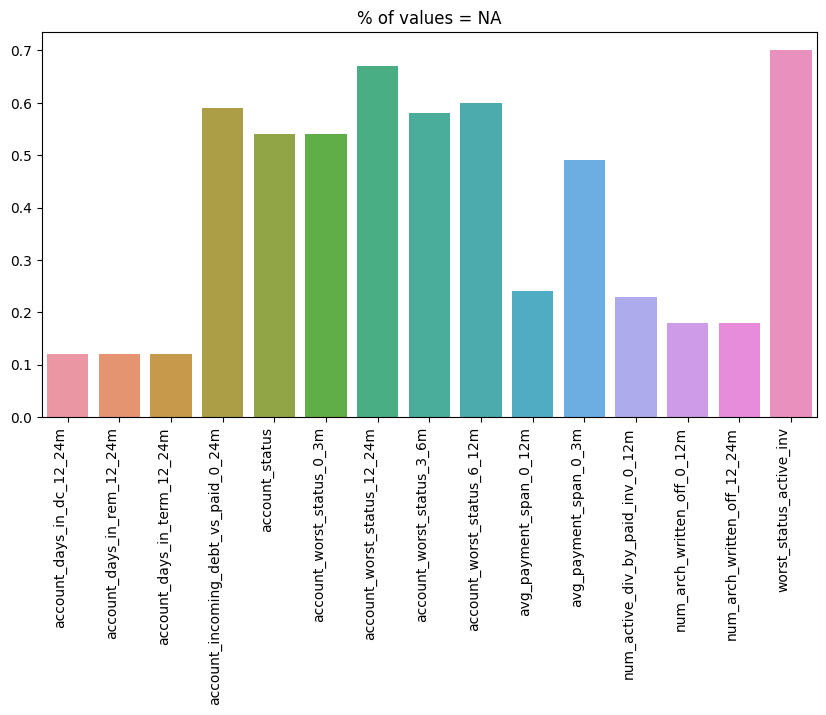

In [5]:
# Explore the dataset, in particular look at the NA counts
has_na = []
for col in df.columns:
    perc_na = 0
    perc_na = round(df[col].isna().sum()/len(df), 2)
    if perc_na > 0:
        has_na.append([col, perc_na])


# Plot out the columns with NA (their percentages) - no need to show it each time
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
na_plot = sns.barplot(x=[n[0] for n in has_na], y=[n[1] for n in has_na],  ax=ax)
na_plot.set_xticklabels(na_plot.get_xticklabels(), rotation=90, horizontalalignment='right')
na_plot.set_title("% of values = NA");


In [6]:
## Let's explore some of the columns (other than default)
## Look in particular at the columns with high NA.
## Do we need those columns or can we simply drop them?

In [7]:
## Make a list of columns that have high % NA
# % NA threshhold for columns to ignore
na_threshold = .3
cols_to_exclude = [col[0] for col in has_na if col[1] > na_threshold]

In [8]:
## We can see that 'merchant_category', 'merchant_group'
## and 'name_in_email' are categorical (object = string)
## These will either need to be ignored (not a good idea)
## or encoded.

In [9]:
# Have a look at the two 'merchant_' columns
for c in df.columns:
    if(c[:8] == 'merchant'):
            print(df[c].value_counts())
df.info()

Diversified entertainment                                  34781
Youthful Shoes & Clothing                                  10524
Books & Magazines                                           8447
General Shoes & Clothing                                    4162
Concept stores & Miscellaneous                              3969
Sports gear & Outdoor                                       3356
Dietary supplements                                         2777
Diversified children products                               2691
Diversified electronics                                     1627
Prints & Photos                                             1502
Children Clothes & Nurturing products                       1357
Pet supplies                                                1185
Electronic equipment & Related accessories                   946
Hobby articles                                               817
Jewelry & Watches                                            815
Prescription optics      

## Basic Feature Selection

### Look for correlations

In [10]:
def corr_matrix(df):
    correlation_matrix = df.corr()
    column_names = correlation_matrix.columns

    # Convert the correlation matrix into a DataFrame
    corr_df = correlation_matrix.stack().reset_index()

    # Rename the columns
    corr_df.columns = ['feature_1','feature_2', 'correlation']

    # Remove "self correlations"
    no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
    corr_df = corr_df[no_self_correlation]

    # Absolute correlation
    corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

    # Correlation by pairs of features
    return corr_df.sort_values(by="absolute_correlation", ascending=False)

corr_matrix(df).head(10)

,feature_1,feature_2,correlation,absolute_correlation
621,max_paid_inv_0_24m,max_paid_inv_0_12m,0.889912,0.889912
584,max_paid_inv_0_12m,max_paid_inv_0_24m,0.889912,0.889912
818,num_arch_ok_0_12m,num_arch_ok_12_24m,0.864148,0.864148
855,num_arch_ok_12_24m,num_arch_ok_0_12m,0.864148,0.864148
1245,status_max_archived_0_24_months,status_max_archived_0_12_months,0.842982,0.842982
1208,status_max_archived_0_12_months,status_max_archived_0_24_months,0.842982,0.842982
1241,status_max_archived_0_24_months,status_last_archived_0_24m,0.765443,0.765443
1056,status_last_archived_0_24m,status_max_archived_0_24_months,0.765443,0.765443
468,avg_payment_span_0_12m,avg_payment_span_0_3m,0.742573,0.742573
505,avg_payment_span_0_3m,avg_payment_span_0_12m,0.742573,0.742573


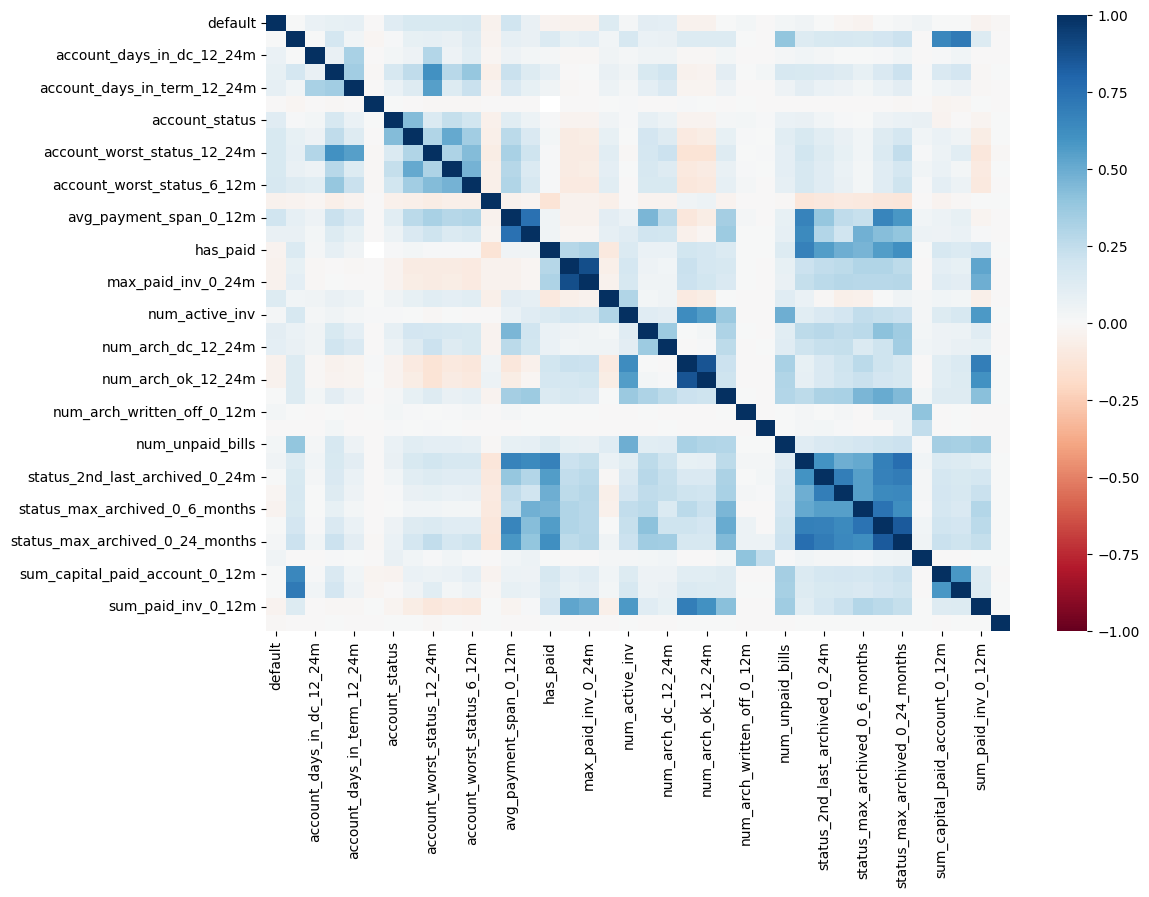

In [26]:
#Plot it
ax = sns.heatmap(df.corr(), vmin=-1, cmap='RdBu')
ax.get_figure().set_size_inches(w=12, h=8)

In [11]:
## There are already 36 columns in the original dataset. A bit less after we
## removed the high percentage NA columns. Before getting into the pipeline
## let's remove some columns that are probably not needed.

## We'll use the list of columns with high NA percentages created during the
## EDA to append additional columns to be excluded.

## First, columns that are highly correlated (corr > .8)
cols_to_exclude +=  ['max_paid_inv_0_24m', 'num_arch_ok_0_12m', 'status_max_archived_0_24_months']

## Next, categorical columns that 'probably' don't add much value
## We still have the 'merchant_group' column that should be usefule
cols_to_exclude += ['merchant_category', 'name_in_email']

## Model - Pipeline

In [12]:
cols_to_exclude += ['default', 'uuid']

# Defining the features and the target
X = df.drop(columns=cols_to_exclude)
y = df['default']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((71980, 28), (17996, 28), (71980,), (17996,))

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71980 entries, 27330 to 16866
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   account_amount_added_12_24m       71980 non-null  int32  
 1   account_days_in_dc_12_24m         63440 non-null  float64
 2   account_days_in_rem_12_24m        63440 non-null  float64
 3   account_days_in_term_12_24m       63440 non-null  float64
 4   age                               71980 non-null  int32  
 5   avg_payment_span_0_12m            54894 non-null  float64
 6   merchant_group                    71980 non-null  object 
 7   has_paid                          71980 non-null  bool   
 8   max_paid_inv_0_12m                71980 non-null  float64
 9   num_active_div_by_paid_inv_0_12m  55542 non-null  float64
 10  num_active_inv                    71980 non-null  int32  
 11  num_arch_dc_0_12m                 71980 non-null  int32  
 12  

In [14]:
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.preprocessing import MinMaxScaler, RobustScaler


In [15]:
# Impute then scale numerical values:
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('scaler', StandardScaler())
])

# Encode categorical values
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# Parallelize "num_transformer" and "cat_transfomer"
numeric_cols = X.select_dtypes(include='number').describe().columns.to_list()
cat_cols = X.select_dtypes(include=['object', 'bool']).describe().columns.to_list()

preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, numeric_cols),
    ('cat_transformer', cat_transformer, cat_cols),
] )

pipeline = Pipeline([
    ('preproces', preprocessor),
    ('model', LogisticRegression(solver='lbfgs', max_iter=1000))
])


In [16]:
preprocessor

ColumnTransformer(transformers=[('num_transformer',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['account_amount_added_12_24m',
                                  'account_days_in_dc_12_24m',
                                  'account_days_in_rem_12_24m',
                                  'account_days_in_term_12_24m', 'age',
                                  'avg_payment_span_0_12m',
                                  'max_paid_inv_0_12m',
                                  'num_active_div_by_paid_inv_0_12m',
                                  'num_active_inv', 'nu...
                                  'status_last_archived_0_24m',
                                  'status_2nd_last_archived_0_24m',
                                  'status_3rd_last_archived_0_24m',
                                  'status_max_archived_0_6_months',
                                  'status_max_archived_0_12_months',
                                  'recovery_debt',
                                  'sum_capital_paid_account_0_12m',
                                  'sum_capital_paid_account_12_24m',
                                  'sum_paid_inv_0_12m', 'time_hours']),
                                ('cat_transformer',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['merchant_group', 'has_paid'])])

In [17]:
X_train_transformed = preprocessor.fit_transform(X_train)

print("Original training set")
display(X_train.head(5))

print("Preprocessed training set")
transformed_df = pd.DataFrame(
    X_train_transformed,
    columns=preprocessor.get_feature_names_out()
)

transformed_df.head(5)

Original training set


,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,age,avg_payment_span_0_12m,merchant_group,has_paid,max_paid_inv_0_12m,num_active_div_by_paid_inv_0_12m,...,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours
27330,0,0.0,0.0,0.0,41,12.545455,Entertainment,True,28367.0,0.00000,...,1,1,1,1,1,0,11895,0,98045,11.871944
36792,0,0.0,0.0,0.0,56,26.000000,Clothing & Shoes,True,2190.0,0.00000,...,1,0,0,0,1,0,0,0,2190,15.135000
41325,0,NaN,NaN,NaN,31,10.967742,Entertainment,True,2993.0,0.03125,...,1,1,1,1,1,0,0,0,46525,19.887500
74231,0,NaN,NaN,NaN,44,7.000000,Entertainment,True,4290.0,0.00000,...,1,1,1,0,1,0,0,0,5475,20.678611
29031,43024,0.0,0.0,0.0,33,15.000000,"Leisure, Sport & Hobby",True,25295.0,0.00000,...,1,1,1,1,1,0,42090,0,40520,19.280278


Preprocessed training set


,num_transformer__account_amount_added_12_24m,num_transformer__account_days_in_dc_12_24m,num_transformer__account_days_in_rem_12_24m,num_transformer__account_days_in_term_12_24m,num_transformer__age,num_transformer__avg_payment_span_0_12m,num_transformer__max_paid_inv_0_12m,num_transformer__num_active_div_by_paid_inv_0_12m,num_transformer__num_active_inv,num_transformer__num_arch_dc_0_12m,...,cat_transformer__merchant_group_Entertainment,cat_transformer__merchant_group_Erotic Materials,cat_transformer__merchant_group_Food & Beverage,cat_transformer__merchant_group_Health & Beauty,cat_transformer__merchant_group_Home & Garden,cat_transformer__merchant_group_Intangible products,cat_transformer__merchant_group_Jewelry & Accessories,"cat_transformer__merchant_group_Leisure, Sport & Hobby",cat_transformer__has_paid_False,cat_transformer__has_paid_True
0,-0.347182,-4.276759e-02,-0.235242,-0.106106,0.385621,-0.484870,1.404694,-0.443957,-0.394238,-0.163973,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.347182,-4.276759e-02,-0.235242,-0.106106,1.541811,0.720565,-0.519094,-0.443957,-0.394238,-0.163973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.347182,-1.045043e-17,0.000000,0.000000,-0.385173,-0.626222,-0.460081,-0.322865,0.267684,-0.163973,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.347182,-1.045043e-17,0.000000,0.000000,0.616859,-0.981705,-0.364762,-0.443957,-0.394238,-0.163973,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.870134,-4.276759e-02,-0.235242,-0.106106,-0.231014,-0.264959,1.178928,-0.443957,-0.394238,-0.163973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [18]:
pipeline

Pipeline(steps=[('preproces',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['account_amount_added_12_24m',
                                                   'account_days_in_dc_12_24m',
                                                   'account_days_in_rem_12_24m',
                                                   'account_days_in_term_12_24m',
                                                   'age',
                                                   'avg_payment_span_0_12m',
                                                   'max_paid_inv_0_12m',
                                                   'num_active_div_by_paid_in...
                                                   'status_3rd_last_archived_0_24m',
                                                   'status_max_archived_0_6_months',
                                                   'status_max_archived_0_12_months',
                                                   'recovery_debt',
                                                   'sum_capital_paid_account_0_12m',
                                                   'sum_capital_paid_account_12_24m',
                                                   'sum_paid_inv_0_12m',
                                                   'time_hours']),
                                                 ('cat_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['merchant_group',
                                                   'has_paid'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [19]:
# Train Pipeline
pipeline.fit(X_train,y_train)

# Make predictions
pipeline.predict(X_test.iloc[0:1])

# Score model
pipeline.score(X_test,y_test)

0.9852189375416759